In [1]:
%load_ext autoreload
%autoreload 2
%load_ext jupyter_black

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import evallm
from automata.fa.dfa import DFA
import tqdm.auto as tqdm

In [3]:
import itertools
from permacache import stable_hash

In [4]:
from evallm.prompting.transducer_prompt import (
    ChainOfThoughtPromptRealExampleNoExplanation,
    BasicSequencePrompt,
    BasicSequencePromptSlightlyMoreExplanation,
    BasicSequencePromptNoChat,
    SequencePromptWithExplanation,
    SequencePromptWithExplanationChainOfThought,
    RedGreenRoomPrompt1,
)
from evallm.experiments.transducer_experiment import (
    current_transducer_experiments,
    compute_relative_to_null,
    compute_relative_to_ngram,
    print_example,
    bottom_quartile_outcome,
    current_dfa_sample_spec,
)
from evallm.experiments.transducer_plotting import (
    plot_all_absolute_results_single_graph,
    plot_absolute_results_barchart,
)

In [5]:
num_states_options_full = (3, 5, 7)

In [6]:
none = current_transducer_experiments(
    "none",
    num_states_options=num_states_options_full,
    num_dfas=1000,
    num_dfas_3_30=1000,
    num_sequence_symbol_options=range(30, 500 + 1, 10),
    just_stats=True,
)

In [7]:
def completion_model(k, m, count=1000):
    return {
        k: current_transducer_experiments(
            m,
            num_states_options=(3,),
            num_dfas=30,
            num_dfas_3_30=count,
            num_sequence_symbol_options=(30,),
            prompt=BasicSequencePromptNoChat.for_setting,
        )
    }

In [8]:
results = {
    # "llama3-8B + original prompt": current_transducer_experiments(
    #     "meta-llama/Meta-Llama-3-8B",
    #     num_states_options=num_states_options_full,
    #     num_dfas=30,
    #     num_sequence_symbol_options=(30, 60, 90, 120, 180, 240, 300, 400, 500),
    # ),
    "llama3-8B": current_transducer_experiments(
        "meta-llama/Meta-Llama-3-8B",
        num_states_options=num_states_options_full,
        # num_states_options=num_states_options_full[:1],
        num_dfas=30,
        num_dfas_3_30=1000,
        num_sequence_symbol_options=(30, 60, 90, 120, 180, 240, 300, 400, 500),
        # num_sequence_symbol_options=(30, 60, 90, 120, 180, 240),
        prompt=BasicSequencePromptNoChat.for_setting,
    ),
    **completion_model(
        "llama3.1-8B-Instruct", "meta-llama/Llama-3.1-8B-Instruct", count=1000
    ),
    **completion_model(
        "Mistral-NeMo-Minitron-8B", "nvidia/Mistral-NeMo-Minitron-8B-Base"
    ),
    # "llama3-8B-instruct": current_transducer_experiments(
    #     "meta-llama/Llama-3.1-8B-Instruct",
    #     num_states_options=(3,),
    #     num_dfas=30,
    #     num_dfas_3_30=1000,
    #     num_sequence_symbol_options=(30,),
    #     prompt=BasicSequencePromptNoChat.for_setting,
    # ),
    **completion_model("gemma-7b", "google/gemma-7b"),
    **completion_model("falcon-7b", "tiiuae/falcon-7b"),
    # "gpt-35-nonchat + original prompt": current_transducer_experiments(
    #     "gpt-3.5-turbo-instruct",
    #     num_dfas=30,
    #     num_states_options=num_states_options_full,
    #     num_sequence_symbol_options=(30, 120, 240, 300, 400),
    # ),
    "gpt-35-nonchat": current_transducer_experiments(
        "gpt-3.5-turbo-instruct",
        num_dfas=30,
        num_states_options=num_states_options_full[:1],
        num_sequence_symbol_options=(30, 120, 240, 300, 400),
        # num_sequence_symbol_options=(30, 120, 240),
        prompt=BasicSequencePromptNoChat.for_setting,
    ),
    "gpt-35-chat": current_transducer_experiments(
        "gpt-3.5-turbo-0125",
        num_dfas=30,
        num_states_options=num_states_options_full[:1],
        num_sequence_symbol_options=(30,),
        # num_sequence_symbol_options=(30, 120, 240),
        prompt=BasicSequencePrompt.for_setting,
    ),
    "gpt-4o-mini": evallm.experiments.transducer_experiment.chatgpt_transducer_experiments(
        "gpt-4o-mini-2024-07-18",
        cot_prompt=BasicSequencePrompt.for_setting,
        num_states_options=num_states_options_full,
        num_sequence_symbol_options=(30, 120, 240, 500),
    ),
    "gpt-4o-mini + slightly more expl": evallm.experiments.transducer_experiment.chatgpt_transducer_experiments(
        "gpt-4o-mini-2024-07-18",
        cot_prompt=BasicSequencePromptSlightlyMoreExplanation.for_setting,
        num_states_options=num_states_options_full[:1],
        num_sequence_symbol_options=(30, 120, 240, 500)[:1],
    ),
    "gpt-4o-mini + red/green v1": evallm.experiments.transducer_experiment.chatgpt_transducer_experiments(
        "gpt-4o-mini-2024-07-18",
        cot_prompt=RedGreenRoomPrompt1.for_setting,
        num_states_options=num_states_options_full[:1],
        # num_sequence_symbol_options=(30, 120,),
        num_sequence_symbol_options=(30, 120, 240, 400),
    ),
    "gpt-4o-mini + explanation": evallm.experiments.transducer_experiment.chatgpt_transducer_experiments(
        "gpt-4o-mini-2024-07-18",
        cot_prompt=SequencePromptWithExplanation.for_setting,
        num_states_options=num_states_options_full,
        num_sequence_symbol_options=(30, 120, 240, 500),
    ),
    "gpt-4o-mini + explanation + cot": evallm.experiments.transducer_experiment.chatgpt_transducer_experiments(
        "gpt-4o-mini-2024-07-18",
        cot_prompt=SequencePromptWithExplanationChainOfThought.for_setting,
        num_states_options=num_states_options_full,
        num_sequence_symbol_options=(30, 120, 240, 500),
    ),
    "gpt-4o": evallm.experiments.transducer_experiment.chatgpt_transducer_experiments(
        "gpt-4o-2024-05-13",
        cot_prompt=BasicSequencePrompt.for_setting,
        num_states_options=num_states_options_full[:1],
        num_sequence_symbol_options=(30, 120, 240, 500),
        num_dfas_3_30=30,
    ),
    "claude-3.5": evallm.experiments.transducer_experiment.chatgpt_transducer_experiments(
        "claude-3-5-sonnet-20241022",
        cot_prompt=BasicSequencePrompt.for_setting,
        num_states_options=num_states_options_full[:1],
        num_sequence_symbol_options=(30, 120, 240, 500)[:1],
    ),
    "claude-3.5 + slightly more expl": evallm.experiments.transducer_experiment.chatgpt_transducer_experiments(
        "claude-3-5-sonnet-20241022",
        cot_prompt=BasicSequencePromptSlightlyMoreExplanation.for_setting,
        num_states_options=num_states_options_full[:1],
        num_sequence_symbol_options=(30, 120, 240, 500)[:1],
        num_dfas_3_30=100,
    ),
    "claude-3.5 + red/green v1": evallm.experiments.transducer_experiment.chatgpt_transducer_experiments(
        "claude-3-5-sonnet-20241022",
        cot_prompt=RedGreenRoomPrompt1.for_setting,
        num_states_options=num_states_options_full[:1],
        num_sequence_symbol_options=(30, 120, 240, 500)[:1],
        num_dfas_3_30=30,
    ),
}

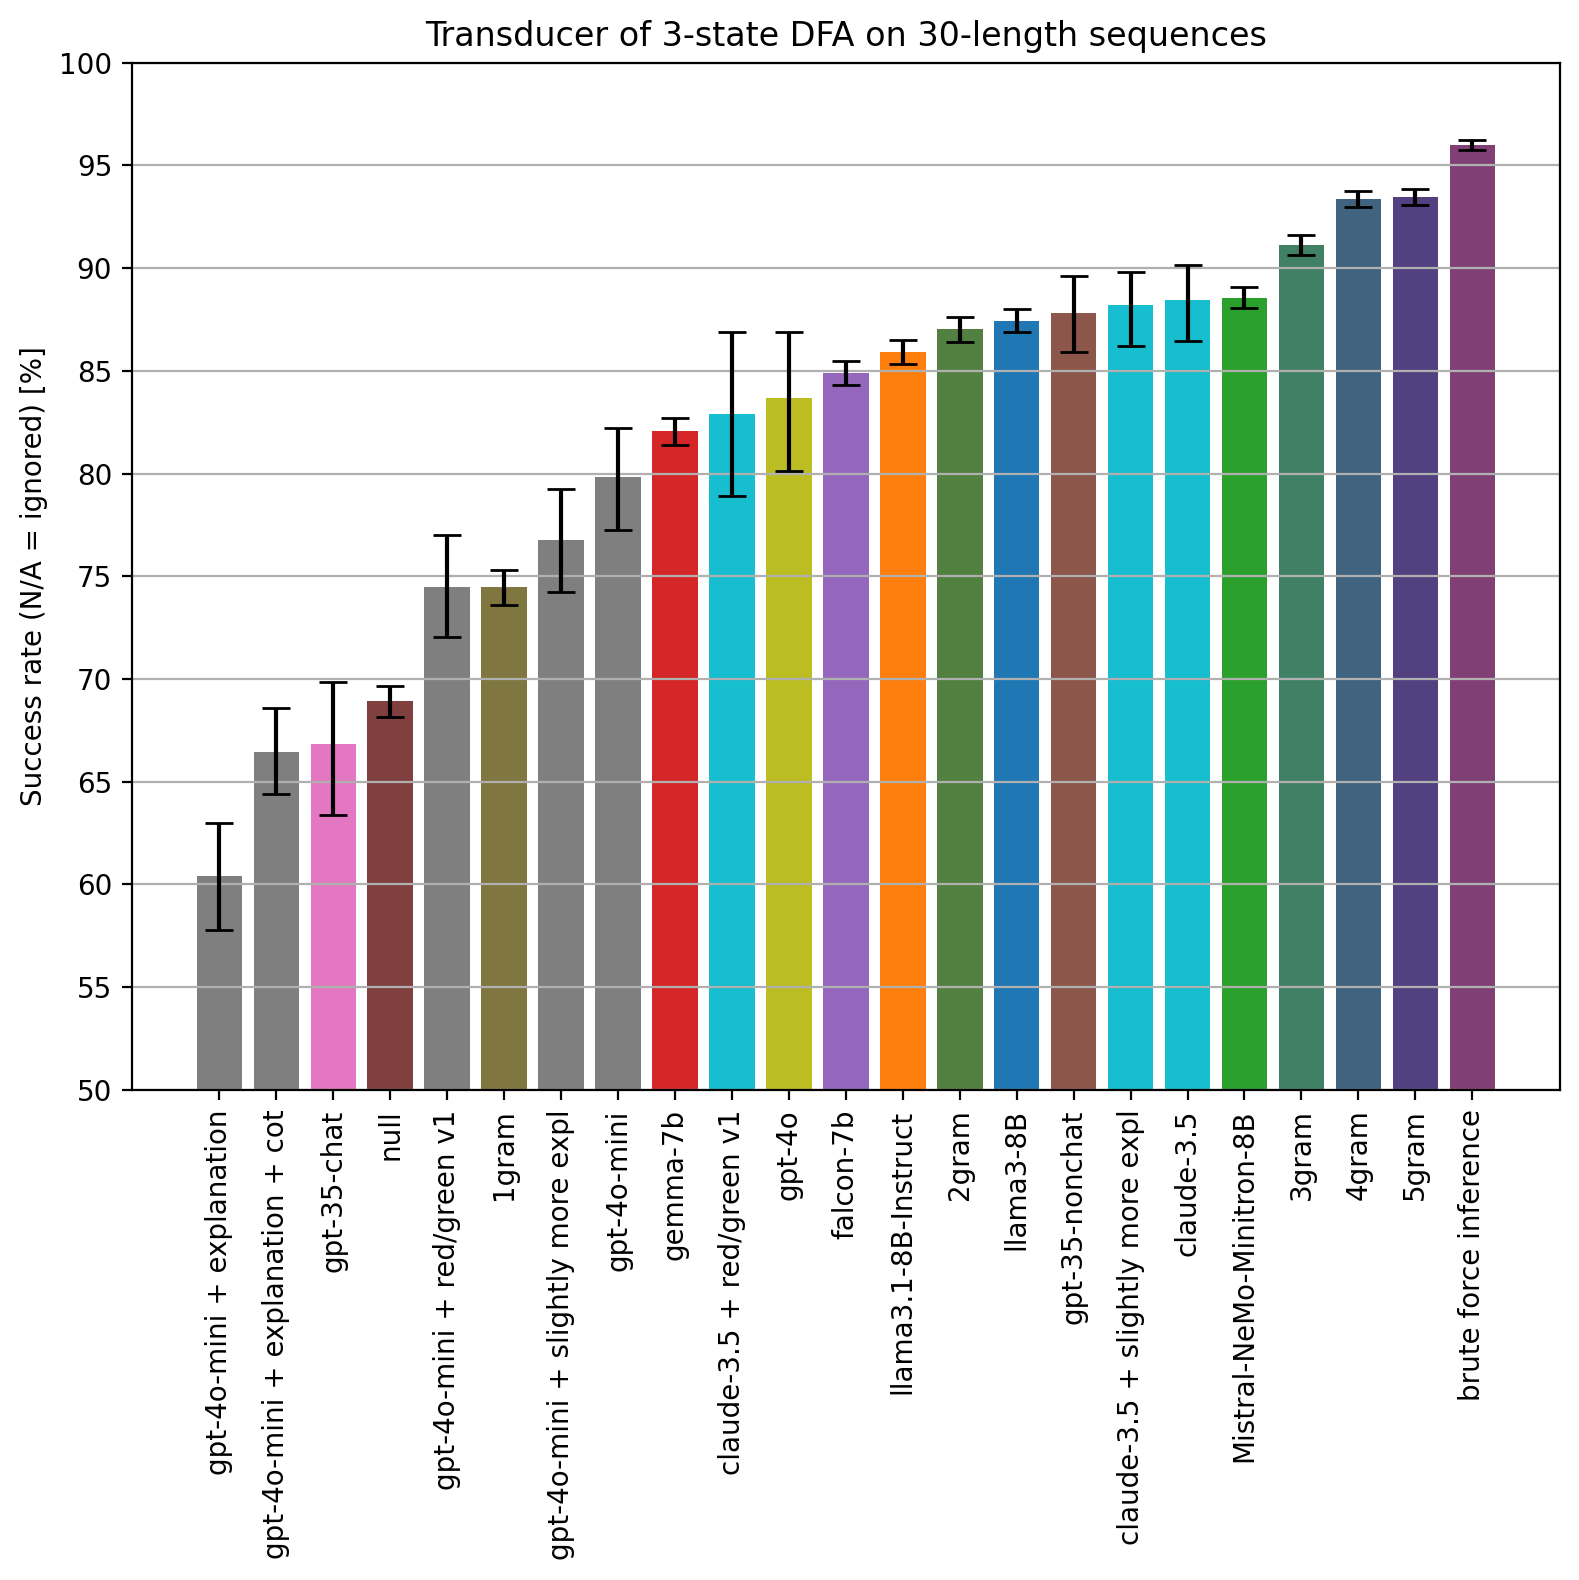

In [9]:
plot_absolute_results_barchart(results, none, 3, 30, ignore_na="na_ignore")

In [10]:
# plot_all_absolute_results_single_graph(results, none, 3, ignore_na="na_ignore")

In [11]:
# plot_all_absolute_results_single_graph(results, none, 3, ignore_na="na_wrong")

In [12]:
# plot_all_absolute_results_single_graph(results, none, 3, ignore_na="na_freq")

In [13]:
# plot_all_absolute_results_single_graph(results, none, 5, ignore_na="na_ignore")

In [14]:
# plot_all_absolute_results_single_graph(results, none, 7, ignore_na="na_ignore")

In [15]:
# num_sequence_symbols = 30
# prompter_basic = evallm.prompting.transducer_prompt.RedGreenRoomPrompt1.for_setting(
#     dict(
#         num_sequence_symbols=num_sequence_symbols,
#         num_states=3,
#         sample_dfa_spec=current_dfa_sample_spec(3),
#     )
# )
# u = results["gpt-4o-mini + red/green v1"][3][num_sequence_symbols]
# print_example(
#     "gpt-4o-mini-2024-07-18",
#     prompter_basic,
#     bottom_quartile_outcome(u),
# )

In [16]:
# num_sequence_symbols = 400
# prompter_basic = evallm.prompting.transducer_prompt.RedGreenRoomPrompt1.for_setting(
#     dict(
#         num_sequence_symbols=num_sequence_symbols,
#         num_states=3,
#         sample_dfa_spec=current_dfa_sample_spec(3),
#     )
# )
# u = results["gpt-4o-mini + red/green v1"][3][num_sequence_symbols]
# print_example(
#     "gpt-4o-mini-2024-07-18",
#     prompter_basic,
#     u[0],
# )